In [33]:
import numpy as np
import pyuvdata
from newcal import (
    caldata,
    calibration_wrappers,
    calibration_optimization,
    cost_function_calculations,
)
import matplotlib.pyplot as plt

In [2]:
THIS_DIR = "/home/rbyrne/newcal/newcal"

In [25]:
test_freq_ind = 0
test_pol_ind = 0
delta_val = 1e-8
amplitude_perturbation = 1.3
use_Nfreqs = 3

In [4]:
# Get data
model = pyuvdata.UVData()
model.read(f"{THIS_DIR}/data/test_model_1freq.uvfits")
data = pyuvdata.UVData()
data.read(f"{THIS_DIR}/data/test_data_1freq.uvfits")

data_copy = data.copy()
model_copy = model.copy()
for ind in range(1, use_Nfreqs):
    data_copy.freq_array += 1e6
    model_copy.freq_array += 1e6 * ind
    data.fast_concat(data_copy, "freq", inplace=True)
    model.fast_concat(model_copy, "freq", inplace=True)

# Added for debugging
data.select(polarizations=[-5], blt_inds=[0, 1], inplace=True)
model.select(polarizations=[-5], blt_inds=[0, 1], inplace=True)

caldata_obj = caldata.CalData()
caldata_obj.load_data(data, model)

caldata_obj.visibility_weights[:, :, :, :] = 1  # Unflag all


Combined frequencies are separated by more than their channel width. This will make it impossible to write this data out to some file types.
Combined frequencies are separated by more than their channel width. This will make it impossible to write this data out to some file types.
Combined frequencies are separated by more than their channel width. This will make it impossible to write this data out to some file types.
Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


In [5]:
caldata_obj.dwcal_inv_covariance = np.random.rand(
    caldata_obj.Ntimes,
    caldata_obj.Nbls,
    caldata_obj.Nfreqs,
    caldata_obj.Nfreqs,
    caldata_obj.N_vis_pols,
) + 1j * np.random.rand(
    caldata_obj.Ntimes,
    caldata_obj.Nbls,
    caldata_obj.Nfreqs,
    caldata_obj.Nfreqs,
    caldata_obj.N_vis_pols,
)
caldata_obj.dwcal_inv_covariance = np.transpose(
    np.matmul(
        np.transpose(caldata_obj.dwcal_inv_covariance, axes=(0, 1, 4, 2, 3)),
        np.conj(np.transpose(caldata_obj.dwcal_inv_covariance, axes=(0, 1, 4, 3, 2))),
    ),
    axes=(0, 1, 3, 4, 2),
)  # Enforce that the matrix is Hermitian

In [26]:
amp_terms_1 = np.copy(caldata_obj.abscal_params[0, :, test_pol_ind])
amp_terms_1[test_freq_ind] += delta_val / 2
print(amp_terms_1)
amp_terms_2 = np.copy(caldata_obj.abscal_params[0, :, test_pol_ind])
amp_terms_2[test_freq_ind] -= delta_val / 2
print(amp_terms_2)

cost1 = cost_function_calculations.cost_function_dw_abscal(
    amp_terms_1,
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)
cost0 = cost_function_calculations.cost_function_dw_abscal(
    amp_terms_2,
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)

amp_jac, phase_jac = cost_function_calculations.jacobian_dw_abscal(
    caldata_obj.abscal_params[0, :, test_pol_ind],
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)

grad_approx = (cost1 - cost0) / delta_val

print(f"Gradient approximation value: {grad_approx}")
print(f"Jacobian value: {amp_jac[test_freq_ind]}")

[1. 1. 1.]
[1. 1. 1.]
DWAbscal cost: 0.23008303671557215
DWAbscal cost: 0.2300812224591118
Gradient approximation value: 181.42564603418342
Jacobian value: 181.42564758524466


In [19]:
for amp_val in [1-delta_val/2, 1+delta_val/2]:
    use_amps = np.array([amp_val, 1, 1])
    cost = cost_function_calculations.cost_function_dw_abscal(
        use_amps,
        caldata_obj.abscal_params[1:, :, test_pol_ind],
        caldata_obj.model_visibilities[:, :, :, test_pol_ind],
        caldata_obj.data_visibilities[:, :, :, test_pol_ind],
        caldata_obj.uv_array,
        caldata_obj.visibility_weights[:, :, :, test_pol_ind],
        caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
    )
    print(cost)

DWAbscal cost: 5659.534569653178
5659.534569653178
DWAbscal cost: 16022.896404559413
16022.896404559413


In [7]:
res_vec = (caldata_obj.data_visibilities-caldata_obj.model_visibilities).flatten()
print(res_vec)

[-0.00899124+0.17314911j -0.00899124+0.17314911j -0.00899124+0.17314911j]


In [8]:
cov_mat = caldata_obj.dwcal_inv_covariance[0,0,:,:,0]
print(cov_mat)

[[1.76897455+0.j         0.93340642+0.22872332j 0.84406295+0.02421241j]
 [0.93340642-0.22872332j 0.70494105+0.j         0.401461  +0.03454489j]
 [0.84406295-0.02421241j 0.401461  -0.03454489j 0.82194899+0.j        ]]


In [9]:
cost_estimated = np.einsum("i,ij,j", np.conj(res_vec), cov_mat, res_vec)
print(cost_estimated)

(0.2300821295863238-4.336808689942018e-19j)


In [10]:
cost = cost_function_calculations.cost_function_dw_abscal(
    caldata_obj.abscal_params[0, :, test_pol_ind],
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)
print(cost)

DWAbscal cost: 0.2300821295863238
0.2300821295863238


In [11]:
jac_estimated = (
    4
    * np.real(np.conj(caldata_obj.data_visibilities.flatten())
    * np.einsum("ij,j", cov_mat, res_vec)
))
print(jac_estimated)

[181.42564759  98.77009937 102.37784575]


In [12]:
jac_estimated = (
    2
    * np.conj(caldata_obj.data_visibilities.flatten())
    * np.einsum("ij,j", cov_mat, res_vec)
) + (
    2
    * caldata_obj.data_visibilities.flatten()
    * np.einsum("ij,j", np.conj(cov_mat), np.conj(res_vec))
)
print(jac_estimated)

[181.42564759+0.j  98.77009937+0.j 102.37784575+0.j]


In [13]:
jac = cost_function_calculations.jacobian_dw_abscal(
    caldata_obj.abscal_params[0, :, test_pol_ind],
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)
print(jac)

(array([181.42564759,  98.77009937, 102.37784575]), array([[1241.42852345, 1176.00330633, 1004.18453684],
       [  99.77947433,   94.5209406 ,   80.71105451]]))


In [27]:
avg_spectra = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/mean_variance_abscal_nbins200_xx.npz"
)
delay_spectrum_variance = avg_spectra["variance"]
bl_length_bin_edges = avg_spectra["bl_bin_edges"]
delay_axis = avg_spectra["delay_array"]

data_path = "/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
model_path = "/safepool/rbyrne/hera_data/interpolated_models/zen.2459861.45004.sum.abs_calibrated.red_avg_model.uvfits"
data = pyuvdata.UVData()
data.read(data_path)
model = pyuvdata.UVData()
model.read(model_path)

data.inflate_by_redundancy(use_grid_alg=True)
model.inflate_by_redundancy(use_grid_alg=True)

# Model does not include all baselines
model_baselines = list(set(list(zip(model.ant_1_array, model.ant_2_array))))
data_baselines = list(set(list(zip(data.ant_1_array, data.ant_2_array))))
use_baselines = [
    baseline
    for baseline in model_baselines
    if (baseline in data_baselines) or (baseline[::-1] in data_baselines)
]
use_polarizations = -5  # Use XX only
data.select(bls=use_baselines, polarizations=use_polarizations)
model.select(bls=use_baselines, polarizations=use_polarizations)

# Align phasing
data.phase_to_time(np.mean(data.time_array))
model.phase_to_time(np.mean(data.time_array))

data.compress_by_redundancy()
model.compress_by_redundancy()

Missing some redundant groups. Filling in available data.
Missing some redundant groups. Filling in available data.


In [28]:
initial_abscal_params = np.zeros((3, 1536, 1))
initial_abscal_params[0, :, 0] = np.random.normal(1.0, scale=.1, size=(1536))
initial_abscal_params[1, :, 0] = np.random.normal(0.0, scale=0.01, size=(1536))
initial_abscal_params[2, :, 0] = np.random.normal(0.0, scale=0.01, size=(1536))

In [30]:
# Run DWAbscal
dwabscal_params = calibration_wrappers.dw_absolute_calibration(
    data,
    data,
    delay_spectrum_variance,
    bl_length_bin_edges,
    delay_axis,
    initial_abscal_params=initial_abscal_params,
    verbose=True,
    xtol=1e-4,
    maxiter=50,
)

print(dwabscal_params)

Reading data...
Formatting data...
Done. Data formatting time 0.004313870271046957 minutes.
Calculating delay weighting matrix...


invalid value encountered in divide


Done. Time calculating delay weighting matrix 4.969100530942281 minutes.
Running calibration optimization...
DWAbscal cost: 12568647144.449415
Initial cost: 12568647144.449415
DWAbscal cost: 12568647144.449415
DWAbscal cost: 25194503518.83907
DWAbscal cost: 23503555038.864895
DWAbscal cost: 7713719545.854509
DWAbscal cost: 4515502655.552569
DWAbscal cost: 4119138877.5500197
DWAbscal cost: 3386827423.2913203
Optimization terminated successfully.
         Current function value: 3386827423.291320
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 4
Optimization terminated successfully.
Optimization time: 34.48926722606023 minutes
DWAbscal cost: 3386827423.2913203
Final cost: 3386827423.2913203
Done. Optimization time: 1536 frequency channels in 34.98424084583918 minutes
Total processing time 39.9533925930659 minutes.
[[[ 8.69448902e-01]
  [ 1.10928463e+00]
  [ 9.94281216e-01]
  ...
  [ 1.02176844e+00]
  [ 9.94314559e-01]

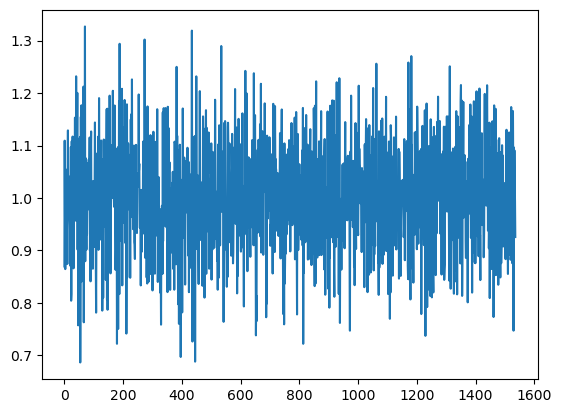

In [37]:
plt.plot(dwabscal_params[0, :, 0])

In [51]:
caldata_obj = caldata.CalData()
caldata_obj.load_data(
    data,
    data,
)
caldata_obj.abscal_params = initial_abscal_params
calibration_wrappers.get_dwcal_weights_from_delay_spectra(
    caldata_obj,
    delay_spectrum_variance,
    bl_length_bin_edges,
    delay_axis,
)

invalid value encountered in divide


In [52]:
def newtons_method_optimizer(
    x0,
    caldata_obj,
    step_size=0.1,
    covergence_condition=0.001,
    maxiters=100,
):

    n_iters = 0
    convergence_iters = 0
    while convergence_iters < 3 and n_iters <= maxiters:
        hess_mat = calibration_optimization.hessian_dw_abscal_wrapper(
            x0, list(range(caldata_obj.Nfreqs)), caldata_obj
        )
        hess_mat_inv = np.linalg.inv(hess_mat)
        del hess_mat
        jac = calibration_optimization.jacobian_dw_abscal_wrapper(
            x0,
            list(range(caldata_obj.Nfreqs)),
            caldata_obj,
        )
        x1 = x0 - step_size * np.matmul(hess_mat_inv, jac)
        del hess_mat_inv
        del jac
        cost = calibration_optimization.cost_dw_abscal_wrapper(
            x0,
            list(range(caldata_obj.Nfreqs)),
            caldata_obj,
        )
        print(f"Iteration {n_iters}, cost func value: {cost}")
        check_conv = np.max(np.abs(x1 - x0))
        if check_conv < covergence_condition:
            convergence_iters += 1
        else:
            convergence_iters = 0
        x0 = x1
        n_iters += 1

    return x1

In [53]:
x1 = newtons_method_optimizer(caldata_obj.abscal_params[:, :, 0].flatten(), caldata_obj)

In [40]:
print(x1)

NameError: name 'x1' is not defined